### 重み行列$\mathbf{A}$の作成

In [1]:
using PyPlot, LinearAlgebra, Random, Distributions, KernelDensity, StatsBase
using PyPlot: matplotlib
Random.seed!(2)
rc("axes.spines", top=false, right=false)

In [2]:
function gabor(x, y, θ, σ=1, λ=2, ψ=0)
    xθ = x * cos(θ) + y * sin(θ)
    yθ = -x * sin(θ) + y * cos(θ)
    return exp(-.5(xθ^2 + yθ^2)/σ^2) * cos(2π/λ * xθ + ψ)
end;

In [3]:
function get_A(WH, Ny)
    Nx = WH^2
    A = zeros(Nx, Ny) # weight matrix
    p = range(-3, 3, length=WH) # position
    θ = (1:Ny) / Ny * π # theta for gabor
    for i in 1:Ny
        gb = gabor.(p', p, θ[i])
        gb /= norm(gb) + 1e-8 # normalization
        A[:, i] = gb[:] # flatten and save
    end
    return A
end;

In [4]:
WH = 16   # width/height of input image
Nx = WH^2 # dimension of the observed variable x
Ny = 50  # dimension of the hidden variable y

A = get_A(WH, Ny);

重み行列$\mathbf{A}$の一部を描画してみよう．

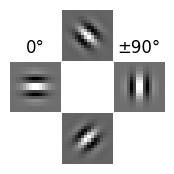

In [5]:
figure(figsize=(2,2))
plot_idx = [2,4,6,8]
weight_idx = [37,25,50,13]
titles = ["", "0°", "±90°", ""]
for i in 1:4
    subplot(3,3,plot_idx[i])
    title(titles[i])
    imshow(reshape(A[:, weight_idx[i]], WH, WH), cmap="gray")
    axis("off")
end
subplots_adjust(wspace=0.01, hspace=0.01)

### 分散共分散行列$\mathbf{C}$の作成
$\mathbf{C}$は$y$の事前分布の分散共分散行列である．{cite:p}`Orban2016-tm`では自然画像を用いて作成しているが，ここでは簡単のため$\mathbf{A}$と同様に{cite:p}`Echeveste2020-sh`に従って作成する．前項で作成した通り，$\mathbf{A}$の各基底には周期性があるため，類似した基底を持つニューロン同士は類似した出力をすると考えられる．Echevesteらは$\theta\in[-\pi/2, \pi/2)$の範囲においてFourier基底を複数作成し，そのグラム行列(Gram matrix)を係数倍したものを$\mathbf{C}$と設定している．ここではガウス過程(Gaussian process)モデルとの類似性から，周期カーネル(periodic kernel) 

$$
K(\theta, \theta')=\exp\left[\phi_1 \cos \left(\dfrac{|\theta-\theta'|}{\phi_2}\right)\right]
$$

を用いる．ここでは$|\theta-\theta'|=m\pi\ (m=0,1,\ldots)$の際に類似度が最大になればよいので，$\phi_2=0.5$とする．これが正定値行列になるように単位行列の係数倍$\epsilon\mathbf{I}$を加算し，スケーリングした上で，`Symmetric(C)`や`Matrix(Hermitian(C)))`により実対象行列としたものを$\mathbf{C}$とする．$\mathbf{C}$を正定値行列にする理由はJuliaの`MvNormal`がCholesky分解を用いて多変量正規分布の乱数を生成するためである． 事前に`cholesky(C)`が実行できるか確認するのもよい．

In [6]:
function get_C(Ny, C_range=[-0.5, 4.0], eps=0.1, ψ₁=2.0, ψ₂=0.5)
    K(x₁, x₂, ψ₁, ψ₂) = exp(ψ₁ * cos(abs(x₁-x₂) / ψ₂)) # periodic kernel
    θ = (1:Ny) / Ny * π # theta for gabor
    C = K.(θ', θ, ψ₁, ψ₂) # create covariance matrix
    C += eps * I # regularization to make C positive definite
    C_min, C_max = minimum(C), maximum(C)
    C = C_range[1] .+ (C_range[2]-C_range[1]) * (C .- C_min) / (C_max - C_min)
    return Symmetric(C); # make symmetric matrix using upper triangular matrix
end;

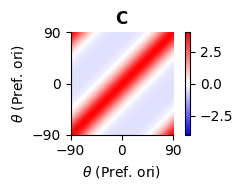

In [7]:
C = get_C(Ny)

figure(figsize=(3,2))
title(L"$\mathbf{C}$")
ims = imshow(C, origin="lower", cmap="bwr", vmin=-4, vmax=4, extent=(-90, 90, -90, 90))
xticks([-90,0,90]); yticks([-90,0,90]); 
xlabel(L"$\theta$ (Pref. ori)"); ylabel(L"$\theta$ (Pref. ori)")
colorbar(ims);
tight_layout()

ここでPref. oriは最適方位 (preferred orientation)を意味する．

### 事後分布の計算
事後分布は$z$と$\mathbf{y}$のそれぞれについて次のように求められる．


$$
\begin{aligned}
p(z \mid \mathbf{x}) &\propto p(z) \mathcal{N}\left(0, z^{2} \mathbf{A C A}^{\top}+\sigma_{x}^{2} \mathbf{I}\right)\\
p(\mathbf{y} \mid z, \mathbf{x})& = \mathcal{N}\left(\mu(z, \mathbf{x}), \Sigma(z)\right)
\end{aligned}
$$

ただし，

$$
\begin{aligned}
\Sigma(z)&=\left(\mathbf{C}^{-1}+\frac{z^{2}}{\sigma_{x}^{2}} \mathbf{A}^{\top} \mathbf{A}\right)^{-1}\\
\mu(z, \mathbf{x})&=\frac{z}{\sigma_{x}^{2}} \Sigma(z) \mathbf{A}^{\top} \mathbf{x}
\end{aligned}
$$

である．

最終的な予測において$z$の事後分布は必要でないため，$p(\mathbf{y} \mid z, \mathbf{x})$から$z$を消去することを考えよう．厳密に行う場合，次式のように周辺化(marginalization)により，$z$を（積分）消去する必要がある．

$$
p(\mathbf{y} \mid \mathbf{x}) = \int dz\ p(z\mid \mathbf{x})\cdot p(\mathbf{y} \mid z, \mathbf{x})
$$

周辺化においては，まず$z$のMAP推定（最大事後確率推定）値 $z_{\mathrm{MAP}}$を求める．

$$
z_{\mathrm{MAP}} = \underset{z}{\operatorname{argmax}} p(z\mid \mathbf{x})
$$

次に$z_{\mathrm{MAP}}$の周辺で$p(z\mid \mathbf{x})$を積分し，積分値が一定の閾値を超える$z$の範囲を求め，この範囲で$z$を積分消去してやればよい．しかし，$z$は単一のスカラー値であり，この手法で推定するのは煩雑であるために近似手法が{cite:p}`Echeveste2017-wu`において提案されている．Echevesteらは第一の近似として，$z$の分布を$z_{\mathrm{MAP}}$でのデルタ関数に置き換える，すなわち，$p(z\mid \mathbf{x})\simeq \delta (z-z_{\mathrm{MAP}})$とすることを提案している．この場合，$z$は定数とみなせ，$p(\mathbf{y} \mid \mathbf{x})\simeq p(\mathbf{y} \mid \mathbf{x}, z=z_{\mathrm{MAP}})$となる．第二の近似として，$z_{\mathrm{MAP}}$を真のコントラスト$z^*$で置き換えることが提案されている．GSMへの入力$\mathbf{x}$は元の画像を$\mathbf{\tilde x}$とすると，$\mathbf{x}=z^* \mathbf{\tilde x}$としてスケーリングされる．この入力の前処理の際に用いる$z^*$を用いてしまおうということである．この場合，$p(\mathbf{y} \mid \mathbf{x})\simeq p(\mathbf{y} \mid \mathbf{x}, z=z^*)$となる．しかし，入力を任意の画像とする場合，$z^*$は未知である．簡便さと精度のバランスを取り，ここでは第一の近似，$z=z_{\mathrm{MAP}}$とする手法を用いることにする．

### シミュレーション

In [8]:
AᵀA = A' * A
ACAᵀ = A * C * A'

σₓ = 1.0 # Noise of the x process
σₓ² = σₓ^2
k, θ = 2.0, 2.0 # Parameter of the gamma dist. for z (Shape, Scale)

C⁻¹ = inv(C); # inverse of C

入力データの作成

In [9]:
Z = [0.0, 0.25, 0.5, 1.0, 2.0] # true contrasts z^*
n_samples = size(Z)[1]
y = rand(MvNormal(zeros(Ny), C), 1) # sampling from P(y)=N(0, C)
X = hcat([rand(MvNormal(vec(z*A*y), σₓ*I)) for z in Z]...)';

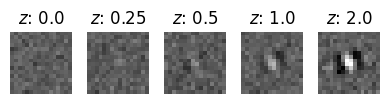

In [10]:
x_min, x_max = minimum(X), maximum(X)

figure(figsize=(4,2))
for s in 1:n_samples
    subplot(1, n_samples, s)
    title(L"$z$: "*string(Z[s]))
    imshow(reshape(X[s, :], WH, WH), vmin=x_min, vmax=x_max, cmap="gray")
    axis("off")
end
tight_layout()

事後分布の計算をする．

### 出力のサンプリング

In [11]:
membrane_potential(y, α=2.4, β=1.9, γ=0.6) = α * max(0, y+β)^γ

membrane_potential (generic function with 4 methods)

事後分布から応答をサンプリングする．

## 興奮性・抑制性神経回路によるサンプリング
前節で実装したMCMCを**興奮性・抑制性神経回路 (excitatory-inhibitory [E-I] network)** で実装する．HMCとLMCの両方を神経回路で実装する．

Hamiltonianを用いる場合，一般化座標$\mathbf{q}$を興奮性神経細胞の活動$\mathbf{u}$, 一般化運動量$\mathbf{p}$を抑制性神経細胞の活動$\mathbf{v}$に対応させる．

*ToDo: 詳しい説明*

簡単のため，前項で用いた入力刺激のうち，最も$z$が大きいサンプルのみを使用する．

In [12]:
dt = 1e-2 # ms
τ, τl = 10.0, 150.0 # ms
α_in = [1/τ - 1/τl, 1/τ + 1/τl]
α_ext = [1/τl, -1/τ]
ρ = sqrt(2*dt/τl);

nt = 50000
M = cat(ones(1,1), C; dims=(1,2));
x_idx = n_samples # get last x
x = X[x_idx, :]
u_init = [1; zeros(Ny)];

In [24]:
function ∇ᵤlogP(u, x, σₓ², A, C⁻¹)
    z, y = abs(u[1]), u[2:end]
    pred_error = A' * x / σₓ² # prediction error signal
    #pred_error = A' * (x - z*A*y) / σₓ² # prediction error signal
    du = zeros(size(u))
    #du[1] = 0 #sign(u[1]) * (y' * pred_error)
    du[1] = sign(u[1]) * (y' * pred_error - z)
    du[2:end] = z * pred_error - C⁻¹*y
    return du
end

∇ᵤlogP (generic function with 1 method)

In [14]:
∇log_p(u) = ∇ᵤlogP(u, x, σₓ², A, C⁻¹);

In [15]:
function NeuralLMC(∇log_p::Function, u_init::Vector{Float64}, α::Float64, ρ::Float64, dt::Float64, nt::Int)
    d = length(u_init)
    u = zeros(nt, d)
    u[1, :] = u_init

    for t in 1:nt-1
        I_ext = ∇log_p(u[t, :]) # external input
        u[t+1, :] = u[t, :] + dt * (α * I_ext) + ρ * randn(d) 
    end
    return u
end

function NeuralHMC(∇log_p::Function, u_init::Vector{Float64}, M::Matrix{Float64}, 
        α_in::Vector{Float64}, α_ext::Vector{Float64}, ρ::Float64, dt::Float64, nt::Int)
    d = length(u_init)
    u, v = zeros(nt, d), zeros(nt, d)
    u[1, :] = u_init

    for t in 1:nt-1
        I_ext = ∇log_p(u[t, :]) # external input
        I_in = M * (u[t, :] - v[t, :]) # internal input
        u[t+1, :] = u[t, :] + dt * (α_in[1] * I_in + α_ext[1] * I_ext) + ρ * randn(d) 
        v[t+1, :] = v[t, :] + dt * (α_in[2] * I_in + α_ext[2] * I_ext) + ρ * randn(d)
    end
    return u, v
end;

In [25]:
@time u_nlmc = NeuralLMC(∇log_p, u_init, α_ext[1], ρ, dt, nt);

  3.310707 seconds (720.97 k allocations: 351.553 MiB, 0.78% gc time, 0.40% compilation time)


In [26]:
@time u_nhmc, v_nhmc = NeuralHMC(∇log_p, u_init, M, α_in, α_ext, ρ, dt, nt);

  3.640502 seconds (1.40 M allocations: 701.128 MiB, 0.97% gc time)


初めの100msはburn-in期間として除く．またダウンサンプリングする．

In [27]:
L = 100
burn_in = 10000
mcmc_time = (burn_in*dt):(L*dt):(nt*dt); # time for plot

In [28]:
mean_nlmc = mean(u_nlmc[burn_in:L:end, 2:end], dims=2); # pseudo-LFP
mean_nhmc = mean(u_nhmc[burn_in:L:end, 2:end], dims=2);

autocorr_nlmc = autocor(mean_nlmc, 1:length(mean_nlmc)-1);
autocorr_nhmc = autocor(mean_nhmc, 1:length(mean_nhmc)-1);

$z$の推定過程を描画する．また，$z$を除いた$\mathbf{u}$を平均化し，自己相関の度合いを確認する．

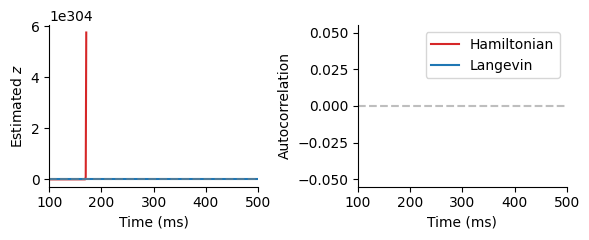

In [29]:
fig, ax = subplots(1,2,figsize=(6,2.5),sharex="all")
ax[1].plot(mcmc_time, u_nhmc[burn_in:L:end, 1], color="tab:red")
ax[1].plot(mcmc_time, u_nlmc[burn_in:L:end, 1], color="tab:blue")
ax[1].axhline(Z[x_idx], linestyle="dashed", color="tab:gray", alpha=0.5)
ax[1].set_xlabel("Time (ms)"); ax[1].set_ylabel(L"Estimated $z$")
ax[1].set_xlim(mcmc_time[1], mcmc_time[end])

ax[2].plot(mcmc_time[1:end-1], autocorr_nhmc, color="tab:red", label="Hamiltonian")
ax[2].plot(mcmc_time[1:end-1], autocorr_nlmc, color="tab:blue", label="Langevin")
ax[2].set_xlabel("Time (ms)"); ax[2].set_ylabel("Autocorrelation")
ax[2].set_xlim(mcmc_time[1], mcmc_time[end])
ax[2].axhline(0, linestyle="dashed", color="tab:gray", alpha=0.5)
ax[2].legend()
fig.tight_layout()

Hamiltonianネットワークは自己相関を振動により低下させることで，効率の良いサンプリングを実現している．

*ToDo: 普通にMCMCやる場合も自己相関は確認したほうがいいという話をどこかに書く．*

推定された事後分布を特定の神経細胞のペアについて確認する．

In [21]:
unit_idx = [1, 25]

2-element Vector{Int64}:
  1
 25

In [22]:
h_nhmc = membrane_potential.(u_nhmc[burn_in:L:end, :])
h_nlmc = membrane_potential.(u_nlmc[burn_in:L:end, :])

kde_bound = ((3,7),(3,7)) # ((xlo,xhi),(ylo,yhi))
U_nhmc = kde((h_nhmc[:, unit_idx[1]+1], h_nhmc[:, unit_idx[2]+1]), boundary=kde_bound)
U_nlmc = kde((h_nlmc[:, unit_idx[1]+1], h_nlmc[:, unit_idx[2]+1]), boundary=kde_bound);

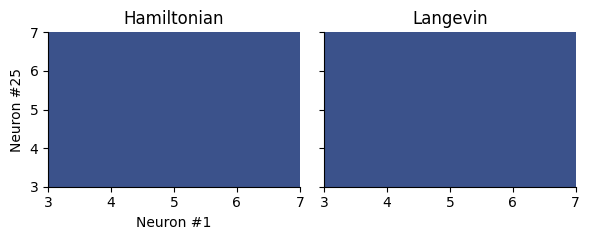

In [23]:
fig, ax = plt.subplots(1,2, figsize=(6, 2.5), sharey="all", sharex="all")
ax[1].contourf(U_nhmc.x, U_nhmc.x, U_nhmc.density)
ax[1].set_title("Hamiltonian")
ax[2].contourf(U_nlmc.x, U_nlmc.x, U_nlmc.density)
ax[2].set_title("Langevin")
ax[1].set_ylabel("Neuron #"*string(unit_idx[2]))
ax[1].set_xlabel("Neuron #"*string(unit_idx[1])) 
fig.tight_layout()